# Wrangle and Analyze Data: WeRateDogs Twitter Account

###### by Ryan Reardon

## Table of Contents
- Introduction
- Data Wrangling
 - Gathering Data
 - Assessing Data
   - Quality
   - Tidiness
 - Cleaning Data
   - Define
   - Code and Test
- Storing, Analyzing, and Visualizing Data
 - Storing
 - Analysis and Visualization
- Conclusion

# Introduction

For this project, we're going to wrangle, analyze and visualize data from WeRateDogs twitter account.

# Data Wrangling

## Gathering Data

#### twitter_archive_enhanced.csv
- WeRateDogs twitter_archive_enhanced.csv is provided by Udacity and downloaded manually.

#### image_predictions.tsv
- image_predictions.tsv is hosted by Udacity servers and downloaded programmatically using the requests library.  This file has images; breed information which is based on computer algorithm and it's accuracy rate.

#### tweet_json.txt
- Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import datetime as dt
import requests
import os
import tweepy
import json
import re

In [2]:
#read in twitter_archive csv as a pandas dataframe
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#check the read in twitter achive csv
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
#use request library to download tsv file from website
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(os.path.join(url.split('/')[-1]), mode = 'wb') as file:
          file.write(response.content)

#read in image-predictions.tsv file downloaded programmatically        
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [784]:
#api object to gather twitter information
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [785]:
#Using the tweet IDs in the WeRateDogs twitter-archive-enhanced.csv
#query the Twitter API for each tweet's JSON data using Python's Tweepy library and store in a list.
tweetid_list = []
tweetid_exceptions = []

for tweet_id in twitter_archive['tweet_id']:
    try:
        tweetid_list.append(api.get_status(tweet_id, tweet_mode = 'extended'))
    except Exception as e:
        tweetid_exceptions.append(tweet_id)

#write list to tweet_json.txt
with open('tweet_json.txt', 'w') as file:
    file.write(json.dumps(tweetid_list, indent=4))

Rate limit reached. Sleeping for: 712
Rate limit reached. Sleeping for: 714


In [786]:
print('List of tweets found:', len(tweetid_list))
print('List of tweets not found:', len(tweetid_exceptions))

List of tweets found: 2341
List of tweets not found: 15


In [6]:
#load tweet_json.txt file and identify columns of interest and store in a list
tweet_final = []

with open('tweet_json.txt', encoding='utf-8') as tweet_js:
    load_tweet_json = json.load(tweet_js)
    for tweet in load_tweet_json:
        tweet_id = tweet['id']
        whole_tweet = tweet['full_text']
        favorite_count = tweet['favorite_count']
        retweet_count = tweet['retweet_count']
        followers_count = tweet['user']['followers_count']
        friends_count = tweet['user']['friends_count']
        url = whole_tweet[whole_tweet.find('https'):]

        #take list items identified add them to a dictionary
        tweet_final.append({'tweet_id': str(tweet_id),
                             'whole_tweet': str(whole_tweet),  
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url})

In [7]:
#Create dataframe from list of dictionaries created from tweet_json.txt file
tweet_json = pd.DataFrame(tweet_final, columns=['tweet_id', 'favorite_count', 'retweet_count',
                                               'followers_count', 'friends_count'])
tweet_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count
0,892420643555336193,38283,8395,7413806,10
1,892177421306343426,32816,6195,7413806,10
2,891815181378084864,24707,4100,7413806,10
3,891689557279858688,41606,8528,7413806,10
4,891327558926688256,39790,9242,7414405,10


## Assessing Data

#### Visual Assessment

- Data gathered for WeRateDogs is displayed in tables below twitter_archive, image_predictions, and tweet_json to assess visually for quality and tidiness issues.

In [9]:
#Display twitter_archive table
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
#display image_predictions table
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [11]:
#display tweet_json table
tweet_json

,tweet_id,favorite_count,retweet_count,followers_count,friends_count
0,892420643555336193,38283,8395,7413806,10
1,892177421306343426,32816,6195,7413806,10
2,891815181378084864,24707,4100,7413806,10
3,891689557279858688,41606,8528,7413806,10
4,891327558926688256,39790,9242,7414405,10
5,891087950875897856,19972,3074,7413806,10
6,890971913173991426,11690,2040,7413806,10
7,890729181411237888,64625,18632,7413806,10
8,890609185150312448,27456,4214,7413806,10
9,890240255349198849,31507,7288,7413806,10


#### Programmatic Assessment

- Using pandas methods etc to identify quality and tidiness issues in the data gathered for WeRateDogs in tables twitter_archive, image_precictions, and tweet_json

In [12]:
#assess the dataframe for missing data, incorrect dataypes etc.
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
#check for duplicate tweet_ids
sum(twitter_archive['tweet_id'].duplicated())

0

In [14]:
#name counts
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Lucy           11
Oliver         11
Cooper         11
Lola           10
Penny          10
Tucker         10
Bo              9
Winston         9
Sadie           8
the             8
Daisy           7
Bailey          7
an              7
Toby            7
Buddy           7
Oscar           6
Leo             6
Dave            6
Jax             6
Milo            6
Jack            6
Koda            6
Stanley         6
Rusty           6
Bella           6
Scout           6
Phil            5
             ... 
Gert            1
Jackie          1
Andru           1
Colin           1
Kramer          1
Alfy            1
Tripp           1
Bobb            1
Jangle          1
Reagan          1
Coopson         1
Venti           1
Rose            1
Rontu           1
Kaia            1
Charleson       1
Tayzie          1
this            1
Tobi            1
Marvin          1
Longfellow      1
Dante           1
Brandi          1
Shikha          1
Kenzie    

In [15]:
#numerator counts
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
#check for fractional numerators
with pd.option_context('max_colwidth', 200):
    display(twitter_archive[twitter_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\rprea\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [17]:
#denominator counts
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
#checks for denominators not equal to 10
with pd.option_context('max_colwidth', 300):
    display(twitter_archive[twitter_archive['rating_denominator'] != 10][['tweet_id','text','rating_numerator',
                                                                                      'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [19]:
#assess the dataframe for missing data, incorrect dataypes etc.
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
#check for duplicates in jpg url column
print(sum(image_predictions['jpg_url'].duplicated()))

66


In [21]:
#assess the dataframe for missing data, incorrect dataypes etc.
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 5 columns):
tweet_id           2342 non-null object
favorite_count     2342 non-null int64
retweet_count      2342 non-null int64
followers_count    2342 non-null int64
friends_count      2342 non-null int64
dtypes: int64(4), object(1)
memory usage: 91.6+ KB


### Quality
#### twitter_archive_enhanced.csv
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp have a lot empty values and some in expanded urls.
- tweet_id dtype is an int, not a str or object
- timestamp column is set as an object, not a datetime object.
- doggo, floofer, pupper, and puppo have a lot of empty values.
- some denominator values are higher than 10, out of a scale of 10 and the numerator values all over place some are enormous and others are small.
- name column has a lot of none submissions, but quite a few submissions which don't look like names like "a".
- extra columns that aren't necessary for analysis.

#### image_predictions.txv
- tweet_id dtype is an int, not a str or object.
- duplicates in jpg_url column.
- 2075 rows in image_predictions table and twitter_archvive has 2356 rows in its table.
- 3 seperate dog breed predictions in 3 columns and confidence level for each is in 3 columns, and True or False on the prediction in 3 columns. Should be one column for breed and one column for confidence with highest level.
- extra columns that aren't necessary for analysis.

#### tweet_json.txt
- no quality issues

### Tidiness
#### twitter_arhive_enhanced.csv
- doggo, floofer, pupper, and puppo columns have their own columns, should be in one column with a a proper column header.

#### image_predictions.tsv
- proper column headers for the dog breed and confidence columns after consolidated.

#### tweet_json.txt
- no tidiness issues.

## Cleaning Data

### Merge the twitter_archive, image_predictions, and tweet_json into one dataframe

In [22]:
#make copies of dataframes
twitter_archive_copy = twitter_archive.copy()
image_predictions_copy = image_predictions.copy()
tweet_json_copy = tweet_json.copy()

#change data types to object to join/merge
twitter_archive_copy.tweet_id = twitter_archive_copy.tweet_id.astype(str)
image_predictions_copy.tweet_id = image_predictions_copy.tweet_id.astype(str)


#merge the dataframes into one dataframe
##save the results to a file
twitter_archive_merge = pd.merge(twitter_archive_copy, image_predictions_copy, how = 'left', on = ['tweet_id'])
twitter_archive_merge = pd.merge(twitter_archive_merge, tweet_json_copy, how = 'left', on = ['tweet_id'])
twitter_archive_merge.to_csv('twitter_archive_merge.csv', index=False, encoding = 'utf-8')

#change tweet_id back to int for analysis
twitter_archive_merge.tweet_id = twitter_archive_merge.tweet_id.astype('int64')

#Test
twitter_archive_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 32 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

### Define
- remove duplicates, retweets and columns that won't be used for analysis
- convert timestamp from object to datetime object
- melt the four dog stage columns and transfer to one column and convert "None" to no_stage 
- drop the individual dog stages once converted to one column
- convert datatypes of rating_numerator and rating_denominator from integer to float
- update rating_numerator with correct fractional rating from text
- delete missing ratings that can't be converted from text or converted using a factor of 10
- update rating_numerator and rating_denminator with correct rating from text
- add a rating column by a factor of 10 due to ratings for multiple dogs in one photo
- drop the rating_numerator and rating_denominator once converted to one column
- convert the erroneous lowercase names and "None" to unidentified or extract dog_name from the text
- condense dog breed predictions into two columns dog_breed and confidence_prediction 
- clean source content url and fill NaN values in one row
- delete additional columns that won't be used for analysis
- rename columns and update dataypes for consistency

### Code and Test

### Remove duplicates, retweets, and columns that won't be used for analysis

In [23]:
#delete retweets
twitter_archive_merge = twitter_archive_merge[pd.isnull(twitter_archive_merge.retweeted_status_id)]

#delete duplicates
twitter_archive_merge = twitter_archive_merge.drop_duplicates()

#delete tweets missing JPG(pictures)
twitter_archive_merge = twitter_archive_merge.dropna(subset= ['jpg_url'])

# removing columns not needed for analysis
twitter_archive_merge.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
        'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#Test
twitter_archive_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null object
floofer               1994 non-null object
pupper                1994 non-null object
puppo                 1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null object
p3                    1994 non-nu

### Convert timestamp from object to datetime object

In [24]:
#convert timestamp from object to datetime object
twitter_archive_merge['timestamp'] = pd.to_datetime(twitter_archive_merge['timestamp'])

#Test
twitter_archive_merge.tweet_id.dtype

dtype('int64')

In [25]:
#Test check dataframe info for datatime change
twitter_archive_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null object
floofer               1994 non-null object
pupper                1994 non-null object
puppo                 1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null object
p3                    199

### Melt the four dog stage columns and transfer to one column and convert "None" to no_stage

In [26]:
#melt doggo, floofer, pupper, and puppo columns and transfer to one column
dog_stage = pd.melt(twitter_archive_merge, id_vars=['tweet_id'], value_vars=['doggo', 'floofer', "pupper", "puppo"])

dog_stage_list = []
for twt_id in dog_stage.tweet_id.unique():
    dog_stage_list.append(dog_stage.query('tweet_id == @twt_id').value.tolist())

repeat_value = []
for rpt in dog_stage_list:
    repeat_value.append(list(set(rpt)))
    
none_value = []
for n in repeat_value:
    if len(n) > 1:
        n.remove('None')
        none_value.append(n)
    else:
        none_value.append(n)

join_value = []
for j in none_value:
    if len(j) > 1:
        join_value.append("|".join(j))
    else:
        join_value.append(j[0])

twitter_archive_merge['dog_stage'] = join_value

In [27]:
#replace None values with no_stage
twitter_archive_merge['dog_stage'] = twitter_archive_merge.dog_stage.replace('None', 'no_stage')

#Test
twitter_archive_merge.dog_stage.value_counts()

no_stage         1688
pupper            203
doggo              63
puppo              22
doggo|pupper        9
floofer             7
doggo|puppo         1
doggo|floofer       1
Name: dog_stage, dtype: int64

### Drop the individual dog stages once converted to one column

In [28]:
# removing extra columns
twitter_archive_merge.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#Test
list(twitter_archive_merge)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorite_count',
 'retweet_count',
 'followers_count',
 'friends_count',
 'dog_stage']

### Convert datatypes or rating_numerator and rating_denominator from integer to float

In [29]:
#convert rating_numerator and denominator to float
twitter_archive_merge[['rating_numerator', 'rating_denominator']] = twitter_archive_merge[['rating_numerator', 
                                                                                         'rating_denominator']].astype(float)

#Test
print('Numerator datatype:', twitter_archive_merge.rating_numerator.dtype)
print('Denominator datatype:', twitter_archive_merge.rating_denominator.dtype)

Numerator datatype: float64
Denominator datatype: float64


### Update rating_numerator with fractional rating from text 

In [30]:
#update fractional numerator rating from text of tweet
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 883482846933004288), 'rating_numerator'] = 13.50
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 832215909146226688), 'rating_numerator'] = 9.75
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 786709082849828864), 'rating_numerator'] = 9.75
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 681340665377193984), 'rating_numerator'] = 9.50
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26

#Test
with pd.option_context('max_colwidth', 300):
    display(twitter_archive_merge[twitter_archive_merge['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\rprea\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0


### Delete missing ratings that can't be converted from text or converted using a factor of 10

In [31]:
#delete tweets without a rating
twitter_archive_merge = twitter_archive_merge[twitter_archive_merge['tweet_id'] != 832088576586297345]
twitter_archive_merge = twitter_archive_merge[twitter_archive_merge['tweet_id'] != 810984652412424192]
twitter_archive_merge = twitter_archive_merge[twitter_archive_merge['tweet_id'] != 686035780142297088]

#Test
with pd.option_context('max_colwidth', 300):
    display(twitter_archive_merge[twitter_archive_merge['rating_denominator'] != 10][['tweet_id','text','rating_numerator',
                                                                                      'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0


### Update rating_numerator and rating_denminator with correct rating from text

In [32]:
# update tweets with correct rating_numerator and rating_denominator from text
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 835246439529840640), 'rating_numerator'] = 13
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 835246439529840640), 'rating_denominator'] = 10

twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 775096608509886464), 'rating_numerator'] = 14
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 775096608509886464), 'rating_denominator'] = 10

twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 740373189193256964), 'rating_numerator'] = 14
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 740373189193256964), 'rating_denominator'] = 10

twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 722974582966214656), 'rating_numerator'] = 13
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 722974582966214656), 'rating_denominator'] = 10

twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 716439118184652801), 'rating_numerator'] = 11
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 716439118184652801), 'rating_denominator'] = 10

twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 682962037429899265), 'rating_numerator'] = 10
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 682962037429899265), 'rating_denominator'] = 10

twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 666287406224695296), 'rating_numerator'] = 9
twitter_archive_merge.loc[(twitter_archive_merge.tweet_id == 666287406224695296), 'rating_denominator'] = 10

#Test
with pd.option_context('max_colwidth', 300):
    display(twitter_archive_merge[twitter_archive_merge['rating_denominator'] != 10][['tweet_id','text','rating_numerator',
                                                                                      'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0


### Add a rating column by a factor of 10 due to ratings for multiple dogs in one photo

In [33]:
#add a rating column and convert to a factor of 10
f = 10
numerator = twitter_archive_merge['rating_numerator']
denominator = twitter_archive_merge['rating_denominator']

twitter_archive_merge['rating'] = f * numerator/denominator.astype(float)

#Test
with pd.option_context('max_colwidth', 300):
    display(twitter_archive_merge[twitter_archive_merge['rating_denominator'] != 10][['tweet_id','text','rating_numerator',
                                                                                      'rating_denominator', 'rating']])

,tweet_id,text,rating_numerator,rating_denominator,rating
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0,12.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0,11.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0,12.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0,11.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0,10.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0,9.0
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0,12.0
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0,11.0
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0,11.0
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0,11.0


In [34]:
#Test: true ratings for special circumstances
with pd.option_context('max_colwidth', 300):
    display(twitter_archive_merge[twitter_archive_merge['rating'] > 15][['tweet_id','text','rating_numerator',
                                                                                      'rating_denominator', 'rating']])

,tweet_id,text,rating_numerator,rating_denominator,rating
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0,10.0,1776.0
2074,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420.0,10.0,420.0


### Drop the rating_numerator and rating_denominator once converted to one column

In [35]:
#removing rating numerator and rating denominator columns
twitter_archive_merge.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

#Test
list(twitter_archive_merge)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'name',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorite_count',
 'retweet_count',
 'followers_count',
 'friends_count',
 'dog_stage',
 'rating']

In [36]:
#Test: check dataframe info
twitter_archive_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2355
Data columns (total 23 columns):
tweet_id           1993 non-null int64
timestamp          1993 non-null datetime64[ns]
source             1993 non-null object
text               1993 non-null object
expanded_urls      1993 non-null object
name               1993 non-null object
jpg_url            1993 non-null object
img_num            1993 non-null float64
p1                 1993 non-null object
p1_conf            1993 non-null float64
p1_dog             1993 non-null object
p2                 1993 non-null object
p2_conf            1993 non-null float64
p2_dog             1993 non-null object
p3                 1993 non-null object
p3_conf            1993 non-null float64
p3_dog             1993 non-null object
favorite_count     1992 non-null float64
retweet_count      1992 non-null float64
followers_count    1992 non-null float64
friends_count      1992 non-null float64
dog_stage          1993 non-null objec

In [37]:
#Test: check rating value counts
twitter_archive_merge.rating.value_counts()

12.00      454
10.00      421
11.00      403
13.00      262
9.00       152
8.00        95
7.00        51
14.00       36
5.00        32
6.00        32
3.00        19
4.00        15
2.00         9
1.00         4
0.00         2
1776.00      1
9.75         1
13.50        1
11.26        1
11.27        1
420.00       1
Name: rating, dtype: int64

### Convert the erroneous lowercase names and "None'" to unidentified or extract dog_name from text

In [38]:
#loop on all the texts and check if the comment has one of the above conditions
#and append the result in a list
names = []

for text in twitter_archive_merge['text']:
    if text.startswith('This is ') and re.match(r'[A-Z].*', text.split()[2]):
        names.append(text.split()[2].strip(',').strip('.'))
    elif text.startswith('Meet ') and re.match(r'[A-Z].*', text.split()[1]):
        names.append(text.split()[1].strip(',').strip('.'))
    elif text.startswith('Say hello to ') and re.match(r'[A-Z].*', text.split()[3]):
        names.append(text.split()[3].strip(',').strip('.'))
    elif text.startswith('Here we have ') and re.match(r'[A-Z].*', text.split()[3]):
        names.append(text.split()[3].strip(',').strip('.'))
    elif 'named' in text and re.match(r'[A-Z].*', text.split()[text.split().index('named') + 1]):
        names.append(text.split()[text.split().index('named') + 1].strip(',').strip('.'))
    # No name specified or other style
    else:
        names.append('unidentified')


twitter_archive_merge['dog_name'] = names

In [39]:
#Test:confirm only real names are left
twitter_archive_merge.dog_name.value_counts()

unidentified    625
Charlie          11
Cooper           10
Lucy             10
Oliver           10
Penny             9
Tucker            9
Sadie             8
Winston           8
Lola              7
Daisy             7
Toby              6
Bella             6
Bo                6
Koda              6
Jax               6
Stanley           6
Louis             5
Milo              5
Buddy             5
Leo               5
Bailey            5
Rusty             5
Chester           5
Scout             5
Oscar             5
Brody             4
Larry             4
Gus               4
Maggie            4
               ... 
Vixen             1
Toffee            1
Finnegus          1
Karl              1
Jomathan          1
Alexanderson      1
Bertson           1
Barclay           1
Grey              1
Berkeley          1
Moreton           1
Davey             1
Travis            1
Anthony           1
Terrenth          1
Glenn             1
Rumpole           1
Tango             1
Dudley            1


### Condense dog breed predictions into two columns dog_breed and confidence_prediction

In [40]:
#store first true dog_breed and level confidence or preciction
dog_breed = []
confidence_prediction = []

#searching first true level of confidence and append to list
#false will have dog_breed text as unidentified
def condense(breed_conf):
    if breed_conf['p1_dog']:
        dog_breed.append(breed_conf['p1'])
        confidence_prediction.append(breed_conf['p1_conf'])
    elif breed_conf['p2_dog']:
        dog_breed.append(breed_conf['p2'])
        confidence_prediction.append(breed_conf['p2_conf'])
    elif breed_conf['p3_dog']:
        dog_breed.append(breed_conf['p3'])
        confidence_prediction.append(breed_conf['p3_conf'])
    else:
        dog_breed.append('unidentified')
        confidence_prediction.append(0)

twitter_archive_merge.apply(condense, axis = 1)

twitter_archive_merge['dog_breed'] = dog_breed
twitter_archive_merge['confidence_prediction'] = confidence_prediction

In [41]:
#Test: changes were made to dataframe
twitter_archive_merge.head()

,tweet_id,timestamp,source,text,expanded_urls,name,jpg_url,img_num,p1,p1_conf,...,p3_dog,favorite_count,retweet_count,followers_count,friends_count,dog_stage,rating,dog_name,dog_breed,confidence_prediction
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,...,False,38283.0,8395.0,7413806.0,10.0,no_stage,13.0,Phineas,unidentified,0.000000
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,...,True,32816.0,6195.0,7413806.0,10.0,no_stage,13.0,Tilly,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,...,True,24707.0,4100.0,7413806.0,10.0,no_stage,12.0,Archie,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,...,False,41606.0,8528.0,7413806.0,10.0,no_stage,13.0,Darla,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,...,True,39790.0,9242.0,7414405.0,10.0,no_stage,12.0,Franklin,basset,0.555712


### Clean the source data url & fill NaN values in one row

In [42]:
#clean content 
twitter_archive_merge['source'] = twitter_archive_merge['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

#Test
twitter_archive_merge.head()

,tweet_id,timestamp,source,text,expanded_urls,name,jpg_url,img_num,p1,p1_conf,...,p3_dog,favorite_count,retweet_count,followers_count,friends_count,dog_stage,rating,dog_name,dog_breed,confidence_prediction
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,...,False,38283.0,8395.0,7413806.0,10.0,no_stage,13.0,Phineas,unidentified,0.000000
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,...,True,32816.0,6195.0,7413806.0,10.0,no_stage,13.0,Tilly,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,...,True,24707.0,4100.0,7413806.0,10.0,no_stage,12.0,Archie,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,...,False,41606.0,8528.0,7413806.0,10.0,no_stage,13.0,Darla,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,...,True,39790.0,9242.0,7414405.0,10.0,no_stage,12.0,Franklin,basset,0.555712


In [43]:
#count of NaN values
twitter_archive_merge.isnull().sum()

tweet_id                 0
timestamp                0
source                   0
text                     0
expanded_urls            0
name                     0
jpg_url                  0
img_num                  0
p1                       0
p1_conf                  0
p1_dog                   0
p2                       0
p2_conf                  0
p2_dog                   0
p3                       0
p3_conf                  0
p3_dog                   0
favorite_count           1
retweet_count            1
followers_count          1
friends_count            1
dog_stage                0
rating                   0
dog_name                 0
dog_breed                0
confidence_prediction    0
dtype: int64

In [44]:
#locate NaN values
twitter_archive_merge.loc[(twitter_archive_merge.retweet_count.isnull())]

,tweet_id,timestamp,source,text,expanded_urls,name,jpg_url,img_num,p1,p1_conf,...,p3_dog,favorite_count,retweet_count,followers_count,friends_count,dog_stage,rating,dog_name,dog_breed,confidence_prediction
932,754011816964026368,2016-07-15 17:56:40,Twitter for iPhone,This is Charlie. He pouts until he gets to go ...,https://twitter.com/dog_rates/status/754011816...,Charlie,https://pbs.twimg.com/media/CnbJuPoXEAAjcVF.jpg,1.0,French_bulldog,0.600985,...,True,NaN,NaN,NaN,NaN,no_stage,12.0,Charlie,French_bulldog,0.600985


In [45]:
#fillNa with "0" for analysis
twitter_archive_merge = twitter_archive_merge.replace(np.nan,0)

#Test
twitter_archive_merge.isnull().sum()

tweet_id                 0
timestamp                0
source                   0
text                     0
expanded_urls            0
name                     0
jpg_url                  0
img_num                  0
p1                       0
p1_conf                  0
p1_dog                   0
p2                       0
p2_conf                  0
p2_dog                   0
p3                       0
p3_conf                  0
p3_dog                   0
favorite_count           0
retweet_count            0
followers_count          0
friends_count            0
dog_stage                0
rating                   0
dog_name                 0
dog_breed                0
confidence_prediction    0
dtype: int64

### Delete additional columns that won't be used for analysis

In [46]:
#drop columns from image predictions
twitter_archive_merge.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
                             'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'name'], axis=1, inplace=True)
#Test
list(twitter_archive_merge)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'jpg_url',
 'favorite_count',
 'retweet_count',
 'followers_count',
 'friends_count',
 'dog_stage',
 'rating',
 'dog_name',
 'dog_breed',
 'confidence_prediction']

### Rename columns and update dataypes for consistency

In [47]:
#updated datatypes for consistency
twitter_archive_merge.tweet_id = twitter_archive_merge.tweet_id.astype('object')
twitter_archive_merge.source = twitter_archive_merge.source.astype('category')
twitter_archive_merge.favorite_count = twitter_archive_merge.favorite_count.astype('int64')
twitter_archive_merge.retweet_count = twitter_archive_merge.retweet_count.astype('int64')
twitter_archive_merge.followers_count = twitter_archive_merge.followers_count.astype('int64')
twitter_archive_merge.friends_count = twitter_archive_merge.friends_count.astype('int64')

#Test
twitter_archive_merge.dtypes

tweet_id                         object
timestamp                datetime64[ns]
source                         category
text                             object
expanded_urls                    object
jpg_url                          object
favorite_count                    int64
retweet_count                     int64
followers_count                   int64
friends_count                     int64
dog_stage                        object
rating                          float64
dog_name                         object
dog_breed                        object
confidence_prediction           float64
dtype: object

In [48]:
#rename columns
twitter_archive_merge = twitter_archive_merge.rename(columns={'text':'tweet', 'source':'tweet_source', 
                                                           'expanded_urls':'tweet_url'})

In [49]:
#Test: confirm column change and dataframe datatypes
twitter_archive_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 1993 non-null object
timestamp                1993 non-null datetime64[ns]
tweet_source             1993 non-null category
tweet                    1993 non-null object
tweet_url                1993 non-null object
jpg_url                  1993 non-null object
favorite_count           1993 non-null int64
retweet_count            1993 non-null int64
followers_count          1993 non-null int64
friends_count            1993 non-null int64
dog_stage                1993 non-null object
rating                   1993 non-null float64
dog_name                 1993 non-null object
dog_breed                1993 non-null object
confidence_prediction    1993 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(4), object(7)
memory usage: 235.6+ KB


# Storing, Analyzing, and Visualizing Data

## Storing

In [50]:
#store cleaned dataframe in a csv file
twitter_archive_merge.to_csv('twitter_archive_master.csv',
                             index=False, encoding ='utf-8')

In [51]:
twitter_archive_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 1993 non-null object
timestamp                1993 non-null datetime64[ns]
tweet_source             1993 non-null category
tweet                    1993 non-null object
tweet_url                1993 non-null object
jpg_url                  1993 non-null object
favorite_count           1993 non-null int64
retweet_count            1993 non-null int64
followers_count          1993 non-null int64
friends_count            1993 non-null int64
dog_stage                1993 non-null object
rating                   1993 non-null float64
dog_name                 1993 non-null object
dog_breed                1993 non-null object
confidence_prediction    1993 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(4), object(7)
memory usage: 235.6+ KB


## Analysis and Visualization

In [52]:
#import packages for visualiztion
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import seaborn as sns

In [53]:
#read in twitter_archive_master csv file
df = pd.read_csv('twitter_archive_master.csv')

#update datatype changes that didn't come through when the csv is read in
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.tweet_id = df.tweet_id.astype('object')
df.tweet_source = df.tweet_source.astype('category')

#Test
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 15 columns):
tweet_id                 1993 non-null object
timestamp                1993 non-null datetime64[ns]
tweet_source             1993 non-null category
tweet                    1993 non-null object
tweet_url                1993 non-null object
jpg_url                  1993 non-null object
favorite_count           1993 non-null int64
retweet_count            1993 non-null int64
followers_count          1993 non-null int64
friends_count            1993 non-null int64
dog_stage                1993 non-null object
rating                   1993 non-null float64
dog_name                 1993 non-null object
dog_breed                1993 non-null object
confidence_prediction    1993 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(4), object(7)
memory usage: 220.1+ KB


### Dog breeeds relationship to other variables

###### Let's look at dog breeds with the most ratings!

In [54]:
#remove unidentified 
breed = df[df['dog_breed'] != 'unidentified']

#volue_counts of dog_breed
breed.dog_breed.value_counts()

golden_retriever                  157
Labrador_retriever                108
Pembroke                           95
Chihuahua                          91
pug                                62
toy_poodle                         51
chow                               48
Pomeranian                         42
Samoyed                            42
malamute                           33
Chesapeake_Bay_retriever           31
French_bulldog                     31
cocker_spaniel                     30
miniature_pinscher                 25
Eskimo_dog                         22
Staffordshire_bullterrier          21
German_shepherd                    21
Cardigan                           21
Shih-Tzu                           20
Siberian_husky                     20
beagle                             20
Rottweiler                         19
Maltese_dog                        19
Shetland_sheepdog                  19
kuvasz                             18
Lakeland_terrier                   18
Italian_grey

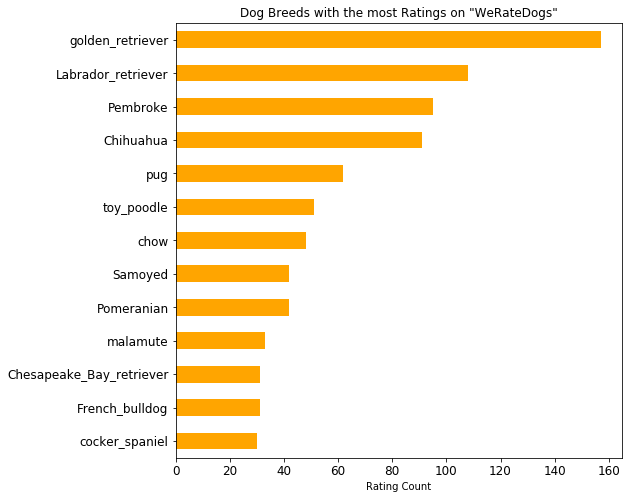

In [55]:
#groupby dog breed and only take counts greater or equal to 30 in ascending order
breed_type = breed.groupby('dog_breed').filter(lambda x: len(x) >= 30)
breed_counts = breed_type['dog_breed'].value_counts().sort_values(ascending = True)

#horizontal barchart of dog breeds with the most ratings on weratedogs
breed_counts.plot(kind = 'barh', fontsize = 12, color = 'orange', figsize=(8,8))
plt.title('Dog Breeds with the most Ratings on "WeRateDogs"')
plt.xlabel('Rating Count')
plt.show();


- These are the dog breeds with the most ratings in the data set.   This could be because they're popular to own, or it's easier to identify(confidence_prediction, or algoritm). 

In [56]:
#groupby and get a description of our sample by dog breed
breed_type.groupby('dog_breed')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_breed,,,,,,,,
Chesapeake_Bay_retriever,31.0,10.838710,1.439833,8.0,10.00,10.0,12.0,13.0
Chihuahua,91.0,10.549451,2.050820,3.0,10.00,11.0,12.0,14.0
French_bulldog,31.0,11.193548,1.796652,8.0,10.00,12.0,12.0,14.0
Labrador_retriever,108.0,11.194444,1.314608,7.0,10.00,11.0,12.0,14.0
Pembroke,95.0,11.410526,1.716594,4.0,11.00,12.0,12.0,14.0
Pomeranian,42.0,10.922619,1.390832,6.0,10.00,11.0,12.0,14.0
Samoyed,42.0,11.690476,1.352290,7.0,11.00,12.0,13.0,14.0
chow,48.0,11.416667,1.350072,7.0,11.00,12.0,12.0,13.0
cocker_spaniel,30.0,11.333333,1.184187,9.0,10.25,11.5,12.0,13.0


In [57]:
#statistal composition by rating of the sample
breed_type['rating'].describe()

count    821.000000
mean      11.150122
std        1.556775
min        3.000000
25%       10.000000
50%       11.000000
75%       12.000000
max       14.000000
Name: rating, dtype: float64

- Stastical compostion of the dog breeds with most ratings, mean 11.15, and std dev 1.56.  Low std.dev indicates the data is clustered around the mean, which make sense considering it's small sample and it's the group with the higher counts.

In [58]:
#statistical composition by rating of the population
df['rating'].describe()

count    1993.000000
mean       11.650166
std        40.649048
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating, dtype: float64

- Stastical compostion of the original dataframe, the population mean is 11.65 seems a bit high and std dev is large at 40.64 indicating data is further spread from the mean.  Remember from cleaning we had outlier ratings for special circumstances 1776 and 420, and our max is 1776.

In [59]:
#exclude the two anomolies or special circumstances from cleaning the data to get better stats
df[df['rating'] <= 20]['rating'].describe()

count    1991.000000
mean       10.558905
std         2.175766
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating, dtype: float64

- Stastical Composition after excluding the outliers of 1776 and 420 gives a population mean of 10.55, and our std dev is small at 2.17 indicating the data is clustering closer to the mean.  Also, our population statistics are now more in line with our sample of the dog breeds with the most rating.

###### Let's look at the top 10 dog breed predictions!

In [60]:
#top10 dog breed predictions by sample
breed_type.sort_values('confidence_prediction', ascending = False)[0:10][['dog_breed', 'confidence_prediction']]

,dog_breed,confidence_prediction
631,chow,0.999953
1129,Labrador_retriever,0.999885
1519,chow,0.999876
980,chow,0.999837
555,chow,0.999823
1383,pug,0.999365
28,French_bulldog,0.999201
82,pug,0.999120
1285,pug,0.999044
1115,French_bulldog,0.998544


In [61]:
#top10 dog breed predictions by population
df.sort_values('confidence_prediction', ascending = False)[0:10][['dog_breed', 'confidence_prediction']]

,dog_breed,confidence_prediction
1845,komondor,0.999956
631,chow,0.999953
1129,Labrador_retriever,0.999885
1519,chow,0.999876
980,chow,0.999837
357,dalmatian,0.999828
555,chow,0.999823
260,Old_English_sheepdog,0.999715
1383,pug,0.999365
1131,Great_Dane,0.999223


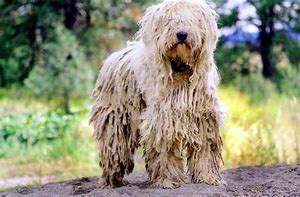

In [62]:
#picture Komondor bog breed with highest likelihood of getting its breed guessed by the algorithm
Image(filename='Komondor.png')

- The top 10 dogs with the highest prediction of breed are dogs that are easily distinguishable, or dogs with looks that standout.  Interesting that the Golden retriever isn't on the list.  The dog breeds with the most ratings is more so do to the breeds popularity and less with algorithm.

###### Let's look at  dog breeds average rating compared to their count!

In [63]:
#crate a dataframe to compares most rated to highest average rating in dog breeds
breed_ct_avg = pd.DataFrame()
breed_ct_avg['dog_breed_ct'] = breed.groupby('dog_breed')['rating'].count()
breed_ct_avg['dog_breed_avg'] = breed.groupby('dog_breed')['rating'].mean()
breed_ct_avg

,dog_breed_ct,dog_breed_avg
dog_breed,,
Afghan_hound,3,9.666667
Airedale,12,9.833333
American_Staffordshire_terrier,16,10.312500
Appenzeller,2,11.000000
Australian_terrier,2,11.500000
Bedlington_terrier,6,10.333333
Bernese_mountain_dog,11,11.272727
Blenheim_spaniel,10,11.100000
Border_collie,12,10.583333


In [64]:
#counts of most rated dog breeds
breed_ct_avg['dog_breed_ct'].sort_values(ascending=False)[0:10]

dog_breed
golden_retriever      157
Labrador_retriever    108
Pembroke               95
Chihuahua              91
pug                    62
toy_poodle             51
chow                   48
Pomeranian             42
Samoyed                42
malamute               33
Name: dog_breed_ct, dtype: int64

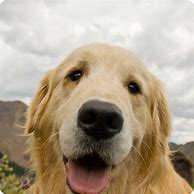

In [65]:
#most rated dog breed the golder retriever
Image(filename='golden_retriever.jpg')

In [66]:
#dog breeds with the highest average ratings
breed_ct_avg['dog_breed_avg'].sort_values(ascending=False)[0:10]

dog_breed
Bouvier_des_Flandres    13.000000
Saluki                  12.500000
briard                  12.333333
Tibetan_mastiff         12.250000
Border_terrier          12.142857
standard_schnauzer      12.000000
silky_terrier           12.000000
Gordon_setter           11.750000
Irish_setter            11.750000
Samoyed                 11.690476
Name: dog_breed_avg, dtype: float64

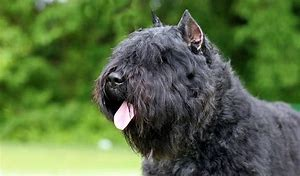

In [67]:
#highest average rating bouvier des flandres
Image(filename='bouvier.jpg')

- Comparing the top 10 dog counts to the top 10 average rating is surprising.  Dog breeds with the most ratings seem to be related to more common dog breeds we see everyday, but less common dog breeds have higher average ratings.

###### Let's look at the Top 10 dog names mentioned in a tweet for fun!

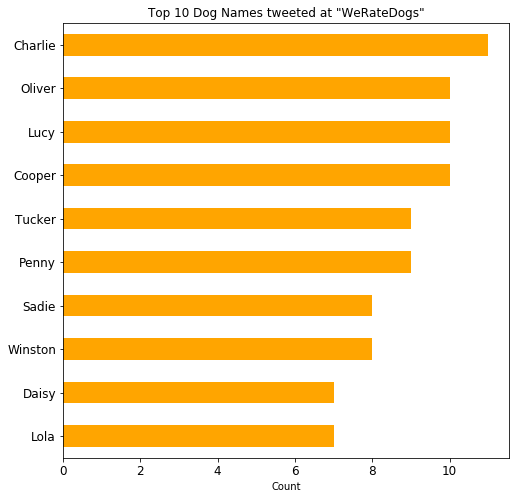

In [68]:
#remove the unidentified dog_name
#only select ratings greater than or equal to 7
#select top10 highest counts in ascending order
dog_names = df[df['dog_name'] != 'unidentified']
name = dog_names.groupby('dog_name').filter(lambda x: len(x) >= 7)
name_counts = name['dog_name'].value_counts().sort_values(ascending = True)

#create horizontal bar chart
name_counts.plot(kind = 'barh', fontsize = 12, color = 'orange', figsize=(8,8))
plt.title('Top 10 Dog Names tweeted at "WeRateDogs"')
plt.xlabel('Count')
plt.show();

- Plotted this for fun; obviously, not super useful for analysis.

In [69]:
#check the counts in ascending order
dog_names.dog_name.value_counts()

Charlie         11
Cooper          10
Oliver          10
Lucy            10
Penny            9
Tucker           9
Winston          8
Sadie            8
Lola             7
Daisy            7
Toby             6
Bella            6
Jax              6
Stanley          6
Bo               6
Koda             6
Louis            5
Bailey           5
Oscar            5
Milo             5
Rusty            5
Chester          5
Leo              5
Scout            5
Buddy            5
Derek            4
Sophie           4
Gus              4
Jack             4
Cassie           4
                ..
Toffee           1
Finnegus         1
Karl             1
Carper           1
Florence         1
Jomathan         1
Alexanderson     1
Bertson          1
Berkeley         1
Moreton          1
Davey            1
Travis           1
Anthony          1
Terrenth         1
Glenn            1
Rumpole          1
Tango            1
Dudley           1
Lorelei          1
Scott            1
Heinrich         1
Franq       

### Relationship between variables

In [70]:
#subset the dataframe to only include qualitative variables
sub_corr = df.loc[:, ['favorite_count','retweet_count','followers_count', 'friends_count', 'rating', 'confidence_prediction']]

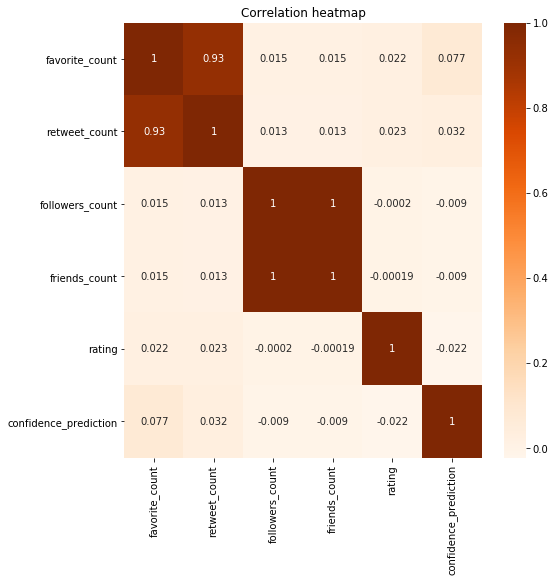

In [71]:
# correlation heatmap
corr = sub_corr.corr()
plt.figure(figsize=(8,8))
plt.title('Correlation heatmap')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot = True,
           cmap='Oranges');

- Other variables show very weak correlations with one another both positive and negative.
- Friend count and follower count show correlation a perfect strong positver correlation, but looking into it further the friend counts are all 10.  
- Retweet count and favorite count shows a stong positve correlation of .93.  Seems realistic, more favorites more retweets.

###### Let's investigate favorite_count and retweet_count some more!

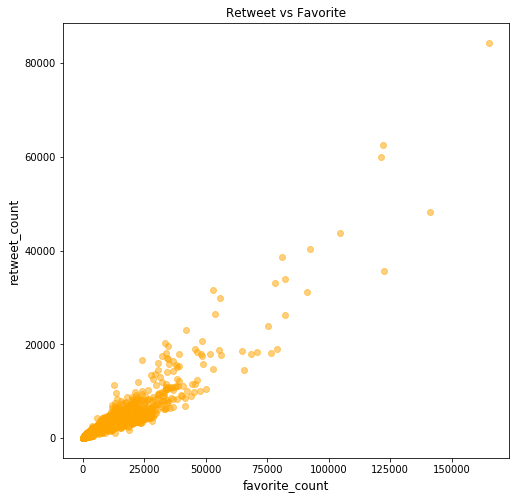

In [72]:
#scatter plot showing a strong positive correlation between favorite count and retweet count
x = sub_corr.favorite_count
y = sub_corr.retweet_count

plt.figure(figsize=(8,8))
plt.scatter(x, y, alpha=0.5,color='orange')
plt.title('Retweet vs Favorite',fontsize=12)
plt.xlabel('favorite_count',fontsize=12)
plt.ylabel('retweet_count',fontsize=12)
plt.show();

- As the correlation map shows, if the count of retweet is high the count of favorites go up and scatterplot shows this visualiztion.

In [73]:
retweet_max = df.loc[(df.retweet_count == max(df.retweet_count)), 'jpg_url']
favorite_max = df.loc[(df.favorite_count == max(df.favorite_count)), 'jpg_url']

print('Max retweet', max(df.retweet_count), 'for tweet', retweet_max,'\n')
print('Max favorite', max(df.favorite_count), 'for tweet', favorite_max)

Max retweet 84335 for tweet 774    https://pbs.twimg.com/ext_tw_video_thumb/74423...
Name: jpg_url, dtype: object 

Max favorite 165086 for tweet 774    https://pbs.twimg.com/ext_tw_video_thumb/74423...
Name: jpg_url, dtype: object


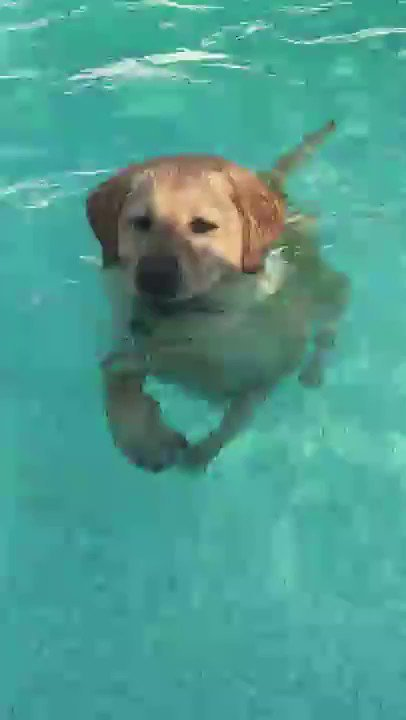

In [74]:
Image(filename='most retweet_favorite.jpg')

###### Let's look at average retweet and favorite over time!

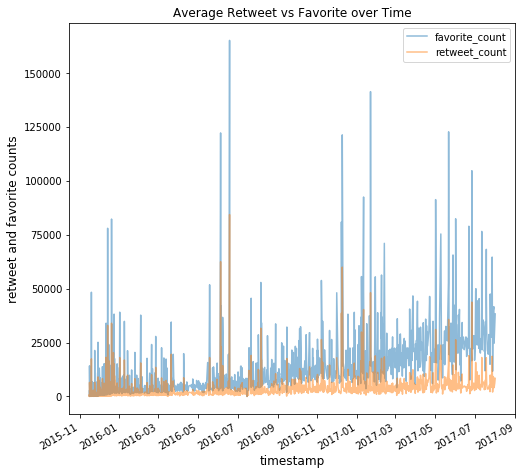

In [75]:
#average retweet and favorite counts over time
means = df.groupby('timestamp')['favorite_count', 'retweet_count'].mean()

#scatterplot comparing the two 
means.plot(kind='line',alpha=0.5, figsize=(8,8))
plt.title('Average Retweet vs Favorite over Time',fontsize=12)
plt.xlabel('timestamp',fontsize=12)
plt.ylabel('retweet and favorite counts',fontsize=12)
plt.show();

In [76]:
#favorite count and retweet counts over time
means.sort_values('favorite_count', ascending=False)

,favorite_count,retweet_count
timestamp,,
2016-06-18 18:26:18,165086,84335
2017-01-21 18:26:02,141329,48119
2017-05-22 00:28:40,122687,35723
2016-06-04 23:31:25,122178,62488
2016-12-09 06:17:20,121275,59957
2017-06-26 19:07:24,104656,43749
2017-01-11 02:15:36,92472,40315
2017-05-02 00:04:57,91264,31063
2017-06-01 20:18:38,82370,26304


- it looks like favorites and retweets increase around holidays and special occasions.  Also, the last two years you can see a gradual increase of average use too.  Probably related to increased popularity.

### Dog Stage Variable Composition

###### Let's look at the breakdown of the dog stage variable!

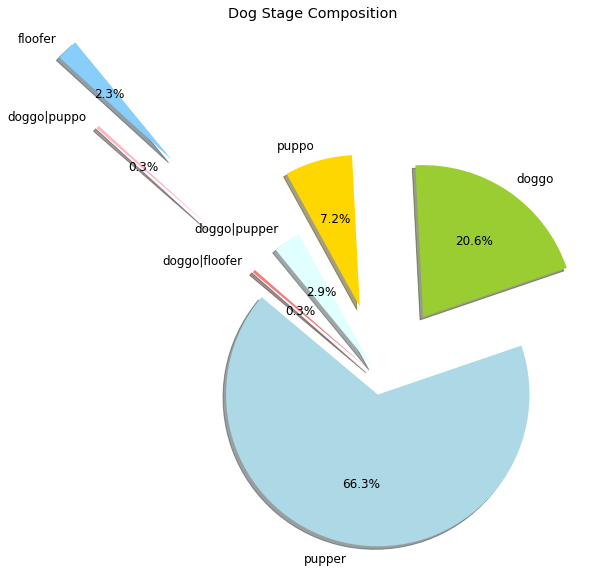

In [77]:
#dog stage counts excluding the no_stage counts to a list
dg = df[df['dog_stage'] != 'no_stage']
labels = dg.dog_stage.value_counts().index.tolist()
sizes = dg.dog_stage.value_counts().tolist()

colors = ['lightblue', 'yellowgreen','gold', 'lightcyan', 'lightskyblue', 'lightpink', 'lightcoral']
explode = (0.1,0.5,0.5,0.1,2,1.5,0.1)

#pie chart dog stages to show percentages
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 12
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Dog Stage Composition')

plt.show();

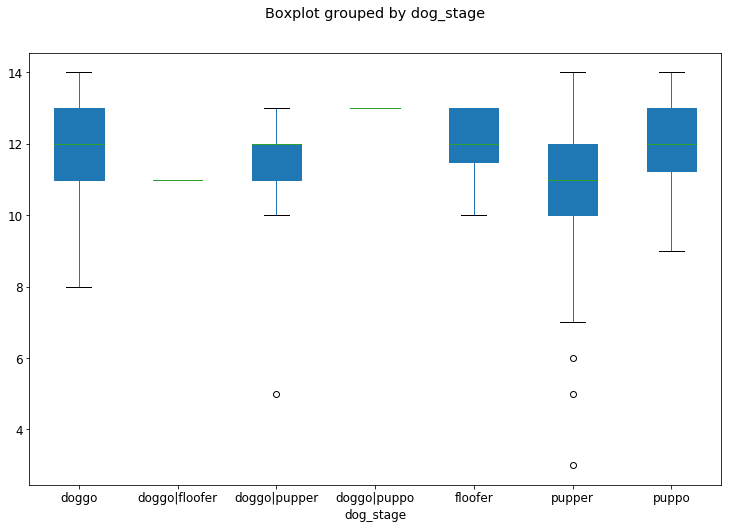

In [78]:
#boxplot of the individual dog stages
dg.boxplot(column = ['rating'], by = 'dog_stage', figsize=(12, 8), 
           grid=False, fontsize=12, patch_artist=True)
plt.title('')
plt.show();

In [79]:
#stats associated with dog stages
des = dg.groupby('dog_stage')['rating'].describe()
med = dg.groupby('dog_stage')['rating'].median()

print(des,'\n')
print(med)

               count       mean       std   min    25%   50%   75%   max
dog_stage                                                               
doggo           63.0  11.888889  1.471351   8.0  11.00  12.0  13.0  14.0
doggo|floofer    1.0  11.000000       NaN  11.0  11.00  11.0  11.0  11.0
doggo|pupper     9.0  11.000000  2.397916   5.0  11.00  12.0  12.0  13.0
doggo|puppo      1.0  13.000000       NaN  13.0  13.00  13.0  13.0  13.0
floofer          7.0  12.000000  1.154701  10.0  11.50  12.0  13.0  13.0
pupper         203.0  10.636798  1.728179   3.0  10.00  11.0  12.0  14.0
puppo           22.0  12.000000  1.309307   9.0  11.25  12.0  13.0  14.0 

dog_stage
doggo            12.0
doggo|floofer    11.0
doggo|pupper     12.0
doggo|puppo      13.0
floofer          12.0
pupper           11.0
puppo            12.0
Name: rating, dtype: float64


- Excluding the tweets with no_stage, pupper represents almost 2/3 of the dog_stage variable and the other 1/3 is made of doggo, floofer, puppo, or combination of both.  Pupper does have the lowest mean; you would expect that with a larger sample and a few outliers, but it does have slightly lower mean than median giving it that slight left skew.

# Conclusion

###### WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. It was started in 2015, and has received international media coverage both for its popularity and in 2017 when it was suspended by twitter.   Dogs are rated on a scale of 10 but almost always exceed the scale because every dog should be rated higher than a 10.

###### From analysis the increased usage and popularity of the twitter account, the hilarious rating scale, a fairly accurate algorithm for recognition of breeds.  The internet language has become main stream; Doggo: dogs, Pupper: puppies, Puppo: puppy, and Floofer: fluffy dog. 

###### Here are a few of the photos tweeted that clearly were rated way above the scale and one isn't a dog; clearly a joke it's Snoop Dogg (rating 420) and Atticus got a bonus points for the celebrating the 4th (rating 1776),  but you get the idea with the twitter account!

In [80]:
#locating the pictures that have rating anomalies
snoop = df.loc[(df.rating == 420), 'jpg_url']
atticus = df.loc[(df.rating == 1776), 'jpg_url']
print(snoop)
print(atticus)

1717    https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg
Name: jpg_url, dtype: object
725    https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg
Name: jpg_url, dtype: object


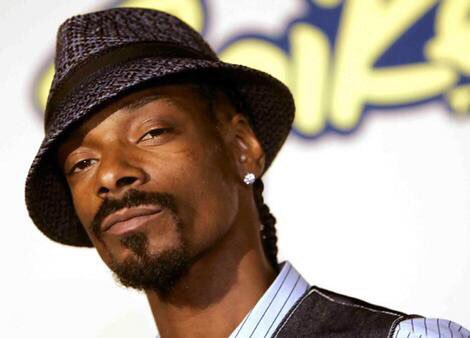

In [81]:
Image(filename='snoop.jpg')

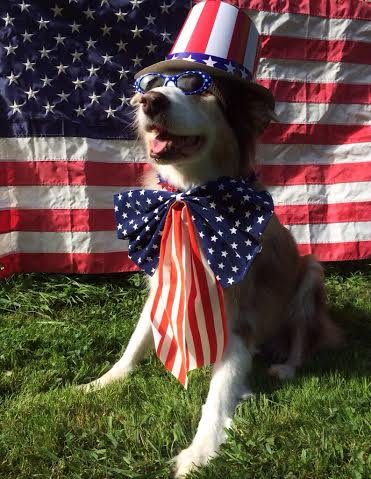

In [82]:
Image(filename='atticus.jpg')